# Simulation Project Phase 2

## Part 1

### Simple EDA

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm


df = pd.read_excel(r"D:\Sharif University of Tech\Term 7\Simulation\Project\Phase 2\Data\surgery_data.xlsx")

In [96]:
df

,Surgery Type,Value (min)
0,Simple Surgery,19.88
1,Simple Surgery,16.33
2,Moderate Surgery,78.88
3,Moderate Surgery,60.03
4,Moderate Surgery,83.10
...,...,...
3995,Simple Surgery,26.10
3996,Simple Surgery,37.46
3997,Moderate Surgery,72.61
3998,Simple Surgery,24.62


In [97]:
df.value_counts()

Surgery Type      Value (min)
Simple Surgery    30.72          7
                  32.56          6
                  32.24          6
                  32.08          6
                  28.80          6
                                ..
Moderate Surgery  77.69          1
                  77.71          1
                  77.76          1
                  77.77          1
Simple Surgery    49.26          1
Name: count, Length: 2870, dtype: int64

In [98]:
grouped = df.groupby('Surgery Type')


for surgery_type, data in grouped:
    print(f"--- {surgery_type} ---")
    print(f"Count: {len(data)}")
    print(f"Mean: {data['Value (min)'].mean():.2f}")
    print(f"Standard Deviation: {data['Value (min)'].std():.2f}")
    print(f"Skewness: {stats.skew(data['Value (min)']):.2f}")
    print(f"Kurtosis: {stats.kurtosis(data['Value (min)']):.2f}")
    print()


--- Complex Surgery ---
Count: 200
Mean: 242.03
Standard Deviation: 63.27
Skewness: -0.14
Kurtosis: 0.74

--- Moderate Surgery ---
Count: 1800
Mean: 74.54
Standard Deviation: 9.95
Skewness: -0.02
Kurtosis: 0.20

--- Simple Surgery ---
Count: 2000
Mean: 30.22
Standard Deviation: 4.96
Skewness: 0.03
Kurtosis: 0.03



### Distribution Plots

In [99]:
simple_surgery = df[df['Surgery Type'] == 'Simple Surgery']['Value (min)']
moderate_surgery = df[df['Surgery Type'] == 'Moderate Surgery']['Value (min)']
complex_surgery = df[df['Surgery Type'] == 'Complex Surgery']['Value (min)']

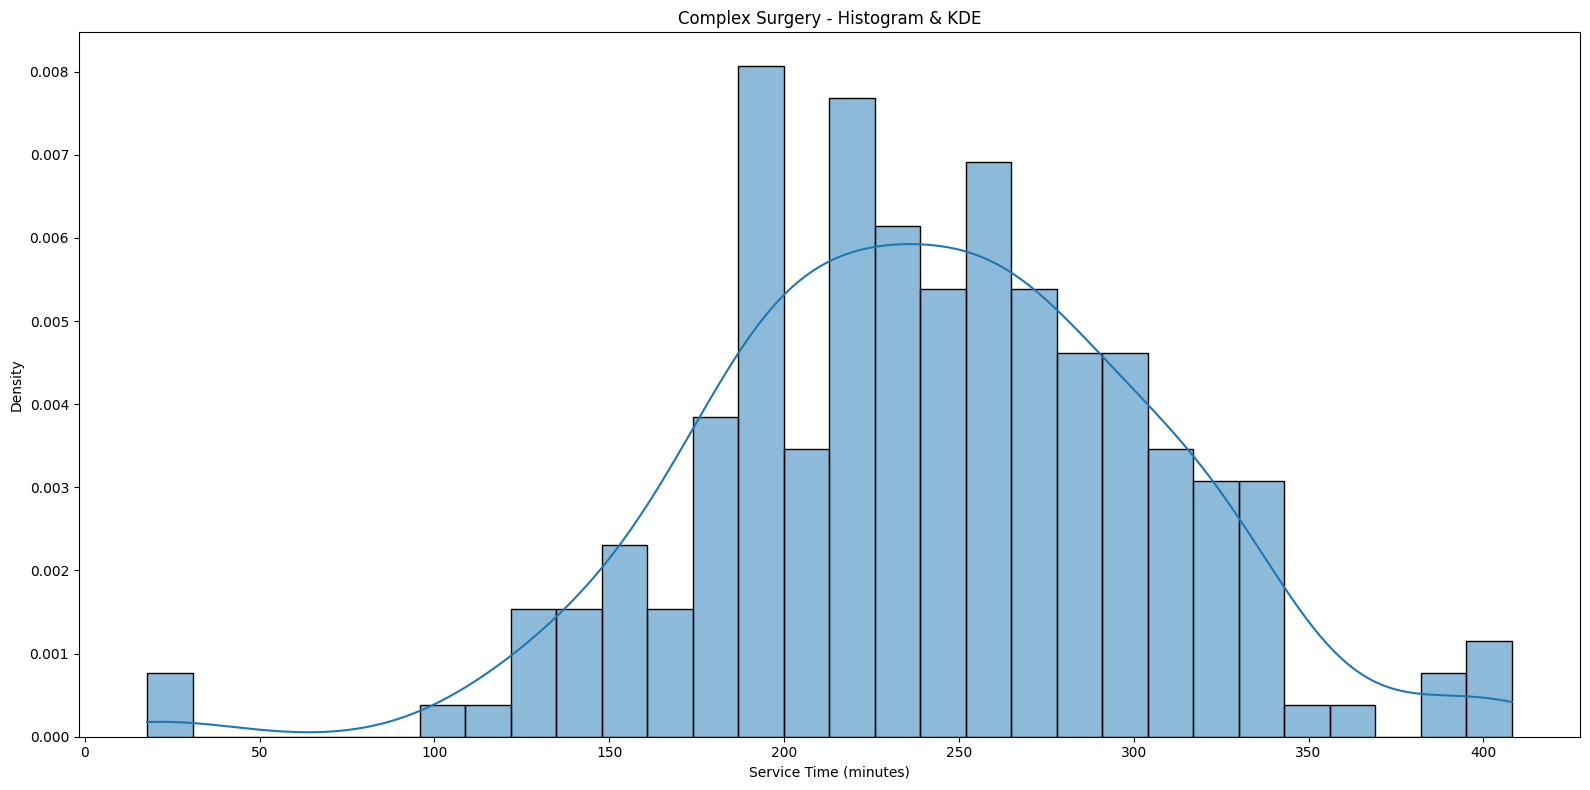

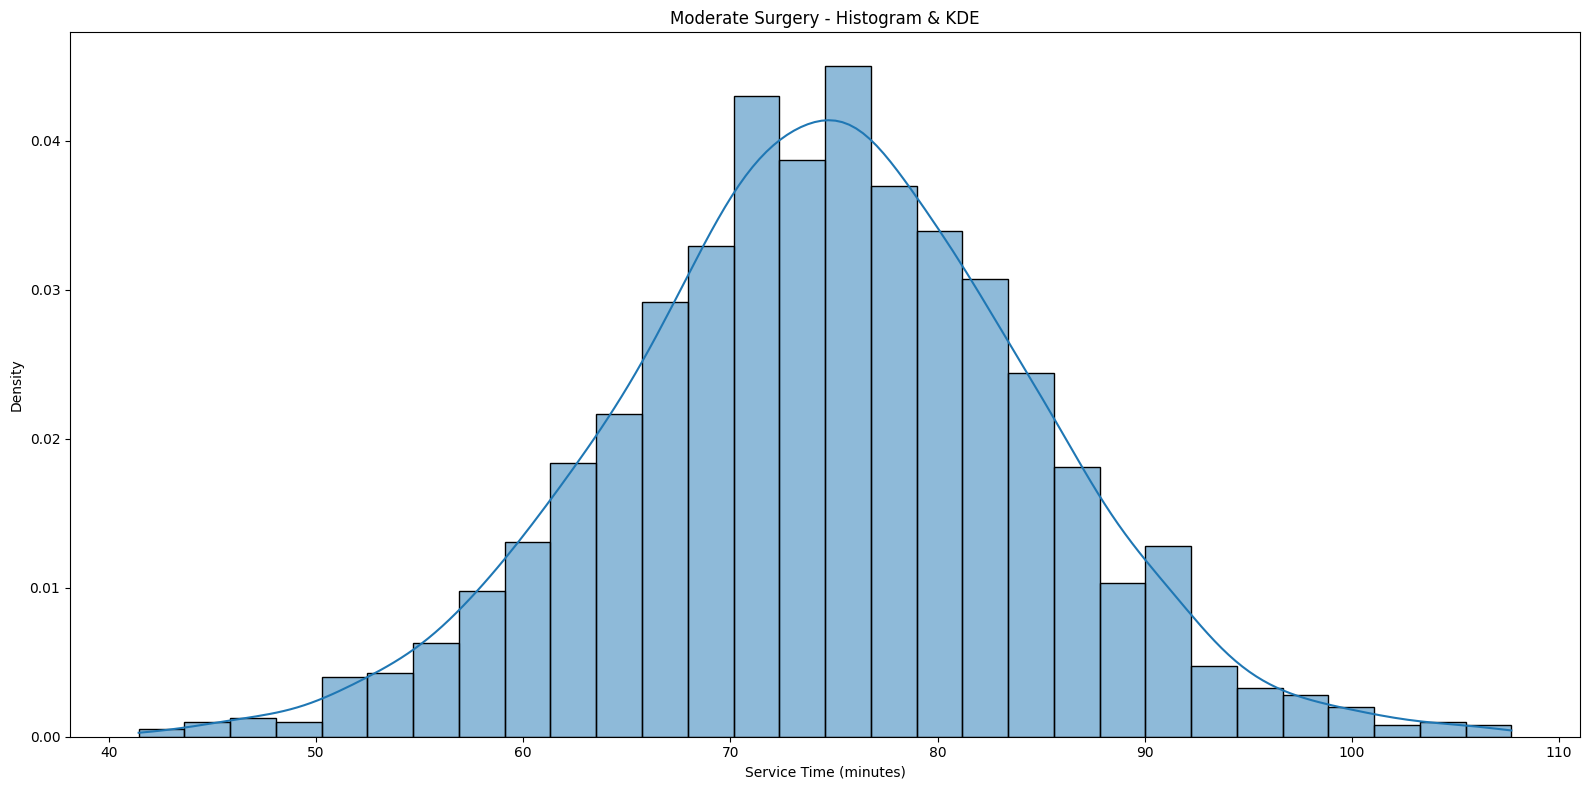

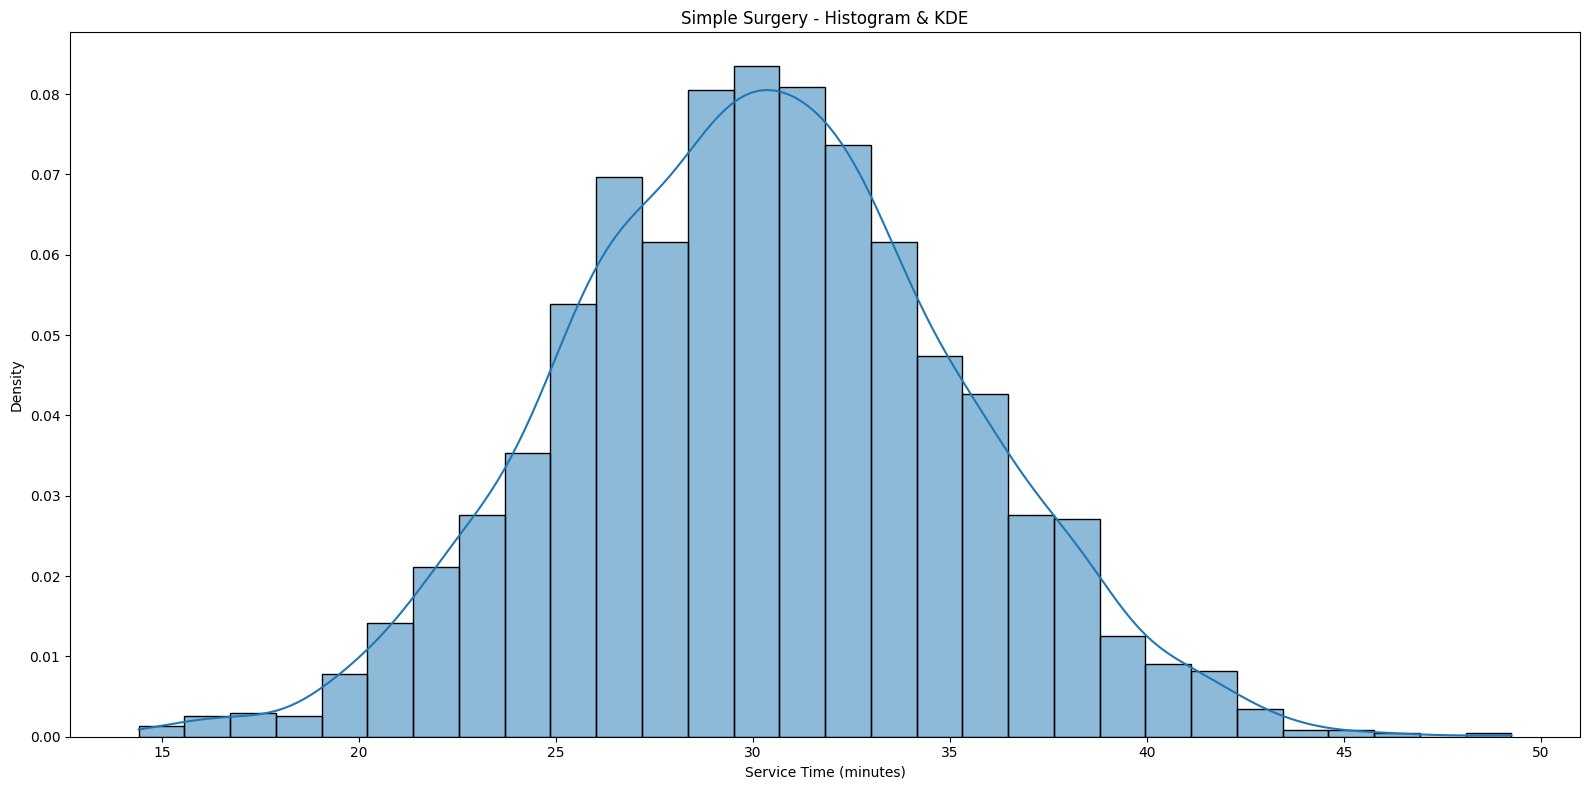

In [100]:
grouped = df.groupby('Surgery Type')



for i, (surgery_type, data) in enumerate(grouped, start=1):
    plt.figure(figsize=(16, 8))
    sns.histplot(data['Value (min)'], kde=True, stat="density", bins=30)
    plt.title(f"{surgery_type} - Histogram & KDE")
    plt.xlabel("Service Time (minutes)")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

### Q-Q Plot

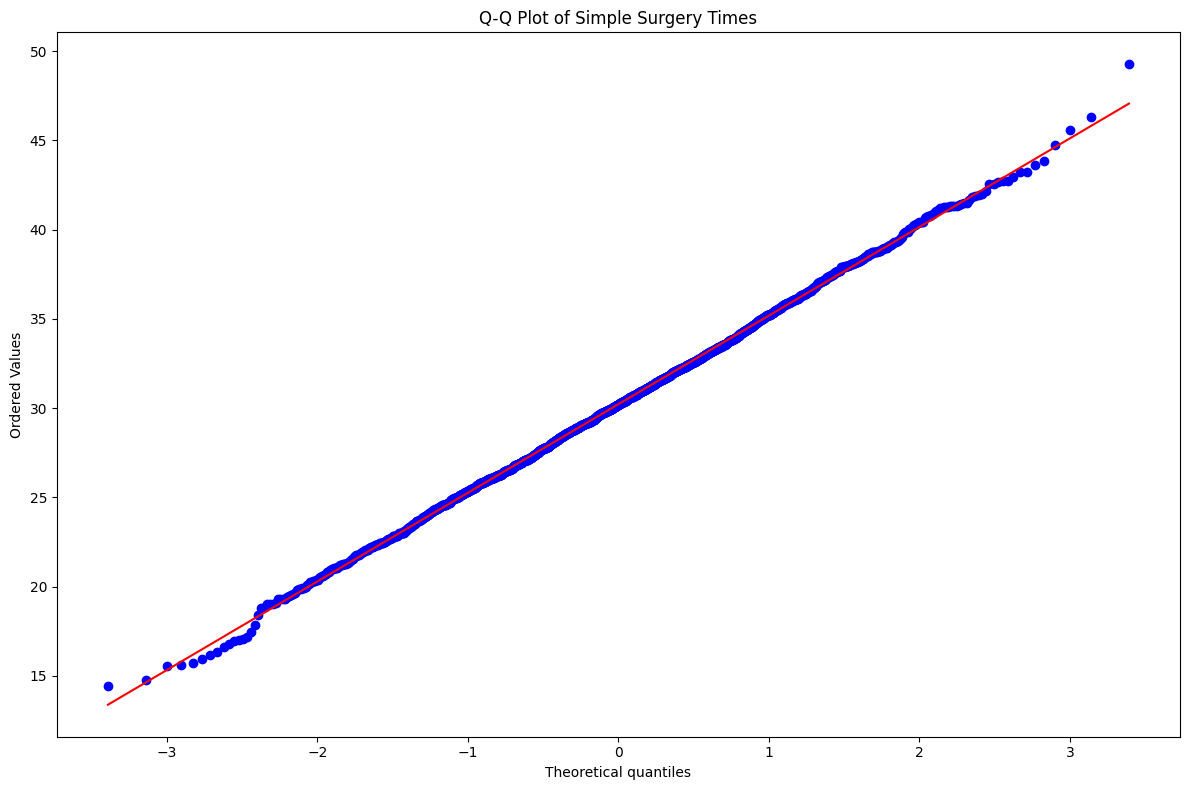

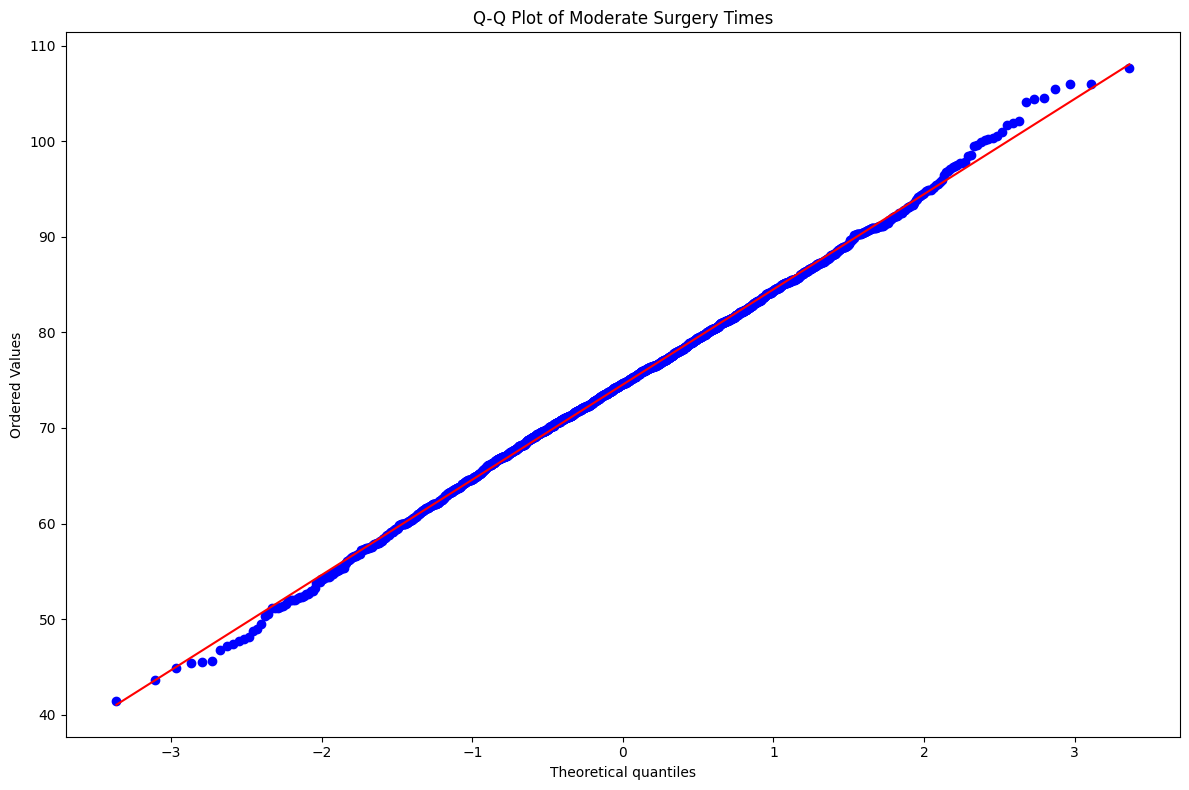

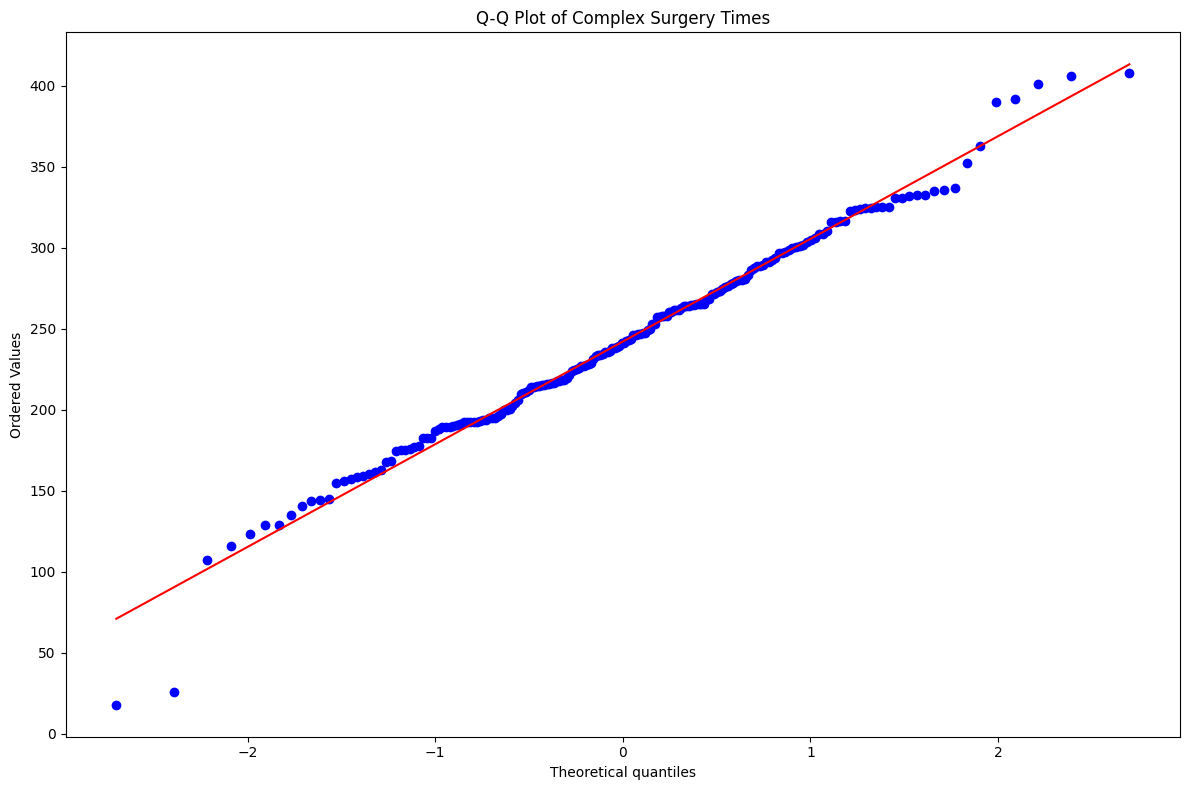

In [101]:
# Simple Surgery
plt.figure(figsize=(12, 8))
stats.probplot(simple_surgery, dist="norm", plot=plt)
plt.title('Q-Q Plot of Simple Surgery Times')
plt.tight_layout()
plt.show()

# Moderate Surgery
plt.figure(figsize=(12, 8))
stats.probplot(moderate_surgery, dist="norm", plot=plt)
plt.title('Q-Q Plot of Moderate Surgery Times')
plt.tight_layout()
plt.show()

# Complex Surgery
plt.figure(figsize=(12, 8))
stats.probplot(complex_surgery, dist="norm", plot=plt)
plt.title('Q-Q Plot of Complex Surgery Times')
plt.tight_layout()
plt.show()

### Skewness Test

In [102]:
simple_skew = simple_surgery.skew()
moderate_skew = moderate_surgery.skew()
complex_skew = complex_surgery.skew()

simple_kurtosis = simple_surgery.kurtosis()
moderate_kurtosis = moderate_surgery.kurtosis()
complex_kurtosis = complex_surgery.kurtosis()

print(f"Simple Surgery Skewness: {simple_skew}, Kurtosis: {simple_kurtosis}")
print(f"Moderate Surgery Skewness: {moderate_skew}, Kurtosis: {moderate_kurtosis}")
print(f"Complex Surgery Skewness: {complex_skew}, Kurtosis: {complex_kurtosis}")


Simple Surgery Skewness: 0.033441878097008534, Kurtosis: 0.03629481092189435
Moderate Surgery Skewness: -0.016346893138414993, Kurtosis: 0.2037080189738325
Complex Surgery Skewness: -0.1420848302883751, Kurtosis: 0.7936944639619141


### Box Plot

C:\Users\Acer\AppData\Local\Temp\ipykernel_15668\1242884001.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Surgery Type', y='Value (min)', data=df, palette='Set2')


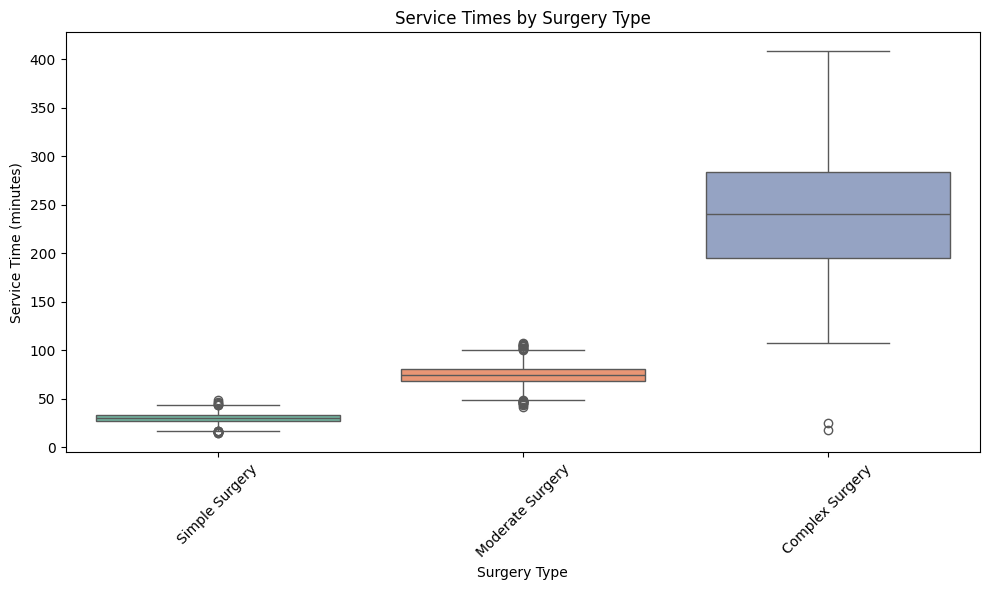

In [103]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Surgery Type', y='Value (min)', data=df, palette='Set2')

plt.title("Service Times by Surgery Type")
plt.xlabel("Surgery Type")
plt.ylabel("Service Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Distribution Fits

#### Fitting & Plotting Functions

In [148]:
def fit_distributions_to_dataframe(data, surgery_type):
    """
    The purpose of this function is to fit distributions mentioned in the list of distributions
    and then to create a results data frame.
    """
    # List of distributions to fit
    distributions = ['norm', 'lognorm', 'gamma', 'expon', 'weibull_min']
    results = []

    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        params = dist.fit(data)  # Fit the distribution to the data
        ks_stat, p_value = stats.kstest(data, dist_name, args=params)  # KS test

        # Append the distribution fit results
        results.append({
            "Distribution": dist_name,
            "KS Statistic": ks_stat,
            "p-value": p_value,
            "Parameters": params
        })

    # Sort results by KS Statistic (ascending)
    df_results = pd.DataFrame(results).sort_values(by="KS Statistic").reset_index(drop=True)

    # Print best-fitting distribution details
    best_fit = df_results.iloc[0]
    best_dist_name = best_fit['Distribution']
    best_params = best_fit['Parameters']

    return df_results


In [149]:
def plot_best_fit(data, surgery_type, df_results):
    """
    The porpose of this function is to plot the best fitting distribution for each of the types of surgeries
    and to visualize them over our original data
    """
    best_fit = df_results.iloc[0]  # Select the best distribution (lowest KS stat)
    dist_name = best_fit['Distribution']
    params = best_fit['Parameters']
    dist = getattr(stats, dist_name)

    # Generate PDF
    x = np.linspace(data.min(), data.max(), 1000)
    pdf = dist.pdf(x, *params)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=30, kde=False, stat='density', color='skyblue', label="Data")
    plt.plot(x, pdf, label=f"Best Fit: {dist_name}", color='red', linewidth=2)
    plt.title(f"{surgery_type} - Best Fit Distribution")
    plt.xlabel("Service Time (min)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

#### Simple Surgery

In [150]:
df_simple_results = fit_distributions_to_dataframe(simple_surgery, "Simple Surgery")

In [151]:
df_simple_results

,Distribution,KS Statistic,p-value,Parameters
0,lognorm,0.010297,9.824111e-01,"(0.010923927827839755, -423.5971837233116, 453..."
1,gamma,0.010303,9.823029e-01,"(3713.4513853407752, -271.886378862593, 0.0813..."
2,norm,0.011250,9.594472e-01,"(30.222215, 4.957647037030268)"
3,weibull_min,0.021884,2.893672e-01,"(3.867809097325705, 12.793718346151831, 19.241..."
4,expon,0.355326,1.910297e-226,"(14.41, 15.812214999999998)"


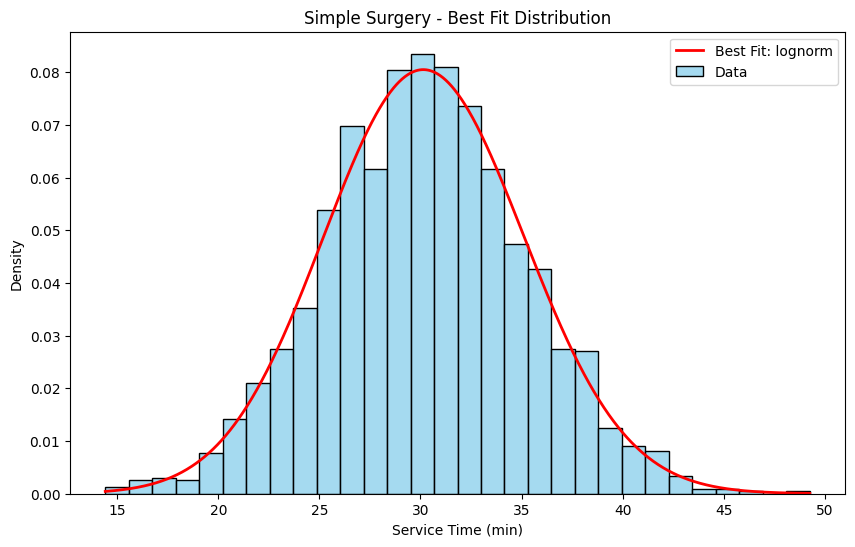

In [152]:
plot_best_fit(simple_surgery, "Simple Surgery", df_simple_results)

#### Moderate Surgery

In [153]:
df_moderate_results = fit_distributions_to_dataframe(moderate_surgery, "Moderate Surgery")

In [154]:
df_moderate_results

,Distribution,KS Statistic,p-value,Parameters
0,norm,0.015484,7.750671e-01,"(74.54242222222223, 9.950457667841523)"
1,lognorm,0.015489,7.747390e-01,"(3.795320292765146e-05, -262102.55999999976, 2..."
2,gamma,0.016250,7.223410e-01,"(16153.35735092398, -1190.351133486879, 0.0783..."
3,weibull_min,0.023269,2.796192e-01,"(4.01997174118021, 38.23601558792858, 39.98097..."
4,expon,0.360882,1.808789e-210,"(41.44, 33.10242222222223)"


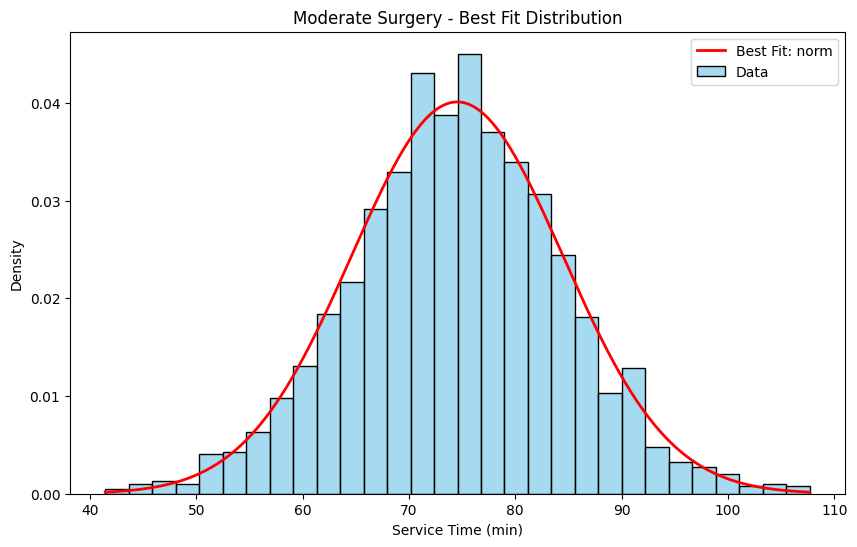

In [155]:
plot_best_fit(moderate_surgery, "Moderate Surgery", df_moderate_results)

#### Complex Surgery

In [156]:
df_complex_results = fit_distributions_to_dataframe(complex_surgery, "Complex Surgery")

In [157]:
df_complex_results

,Distribution,KS Statistic,p-value,Parameters
0,norm,0.037212,9.348690e-01,"(242.03119999999998, 63.11617115731911)"
1,lognorm,0.037212,9.348636e-01,"(7.5238368084928855e-06, -8388590.189999988, 8..."
2,gamma,0.040333,8.876298e-01,"(619.1605610780566, -1339.1151572116605, 2.553..."
3,weibull_min,0.048959,7.049587e-01,"(5.049295403087455, -47.62833884454761, 314.43..."
4,expon,0.397315,5.464783e-29,"(17.81, 224.22119999999998)"


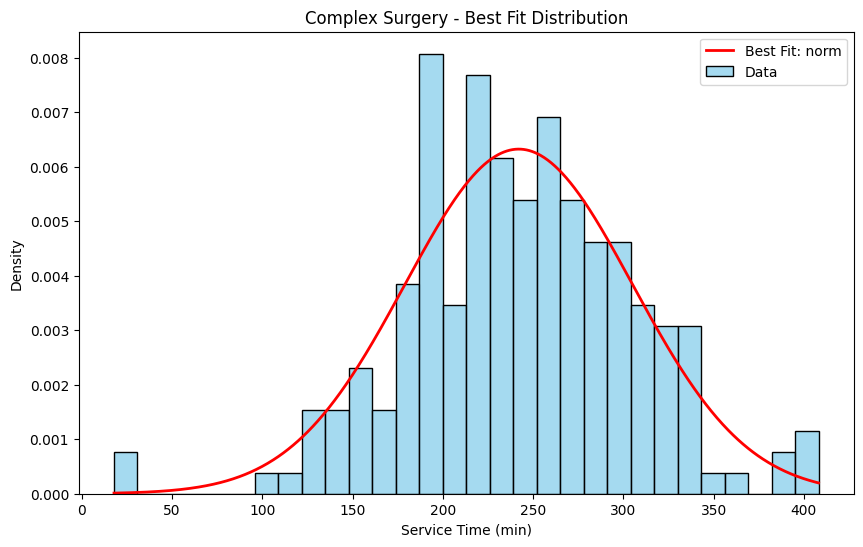

In [158]:
plot_best_fit(complex_surgery, "Complex Surgery", df_complex_results)

## Part 2